In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression

In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200

In [3]:
#read in the train and test data
data = pd.read_feather(r'/media/kchen/2TB/kchen_backup/ssi/data/procol_train.feather')
y = data['ssi']
X = data.drop(['SUPINFEC','WNDINFD','ORGSPCSSI','ssi'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

test = pd.read_feather(r'/media/kchen/2TB/kchen_backup/ssi/data/procol_test.feather')
y_test = test['ssi']
X_test = test.drop(['SUPINFEC','WNDINFD','ORGSPCSSI','ssi'], axis=1)


In [4]:
X_train.shape

(179121, 67)

In [5]:
X_valid.shape

(44781, 67)

In [6]:
y_test.value_counts(normalize=True)

0    0.895161
1    0.104839
Name: ssi, dtype: float64

In [7]:
y_train.value_counts(normalize=True)

0    0.89286
1    0.10714
Name: ssi, dtype: float64

In [8]:
#create a function to evaluate models using AUROC
def evaluate(model1, X, y):
    ppreds = model1.predict_proba(X)
    ppreds = ppreds[:,1]
    pscore = roc_auc_score(y, ppreds)
    print('AUC', pscore)

In [9]:
#define the Random Forest model
model = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=8, max_features='auto', max_depth=20)
model.fit(X_train, y_train)
evaluate(model, X_valid, y_valid)

AUC 0.7420265377180156


In [10]:
evaluate(model, X_test, y_test)

AUC 0.7642216843579279


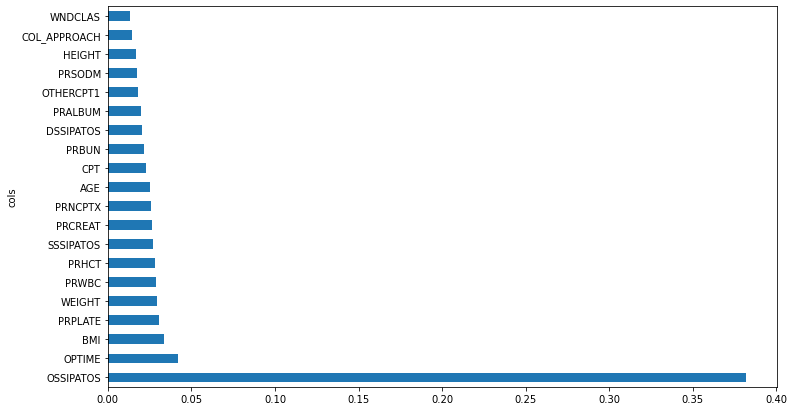

In [11]:
def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

In [12]:
model2 = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0)
model2.fit(X, y)
evaluate(model2, X_valid, y_valid)

/home/kchen/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 0.7806193649856792


In [13]:
evaluate(model2, X_test, y_test)

AUC 0.7667398233020337


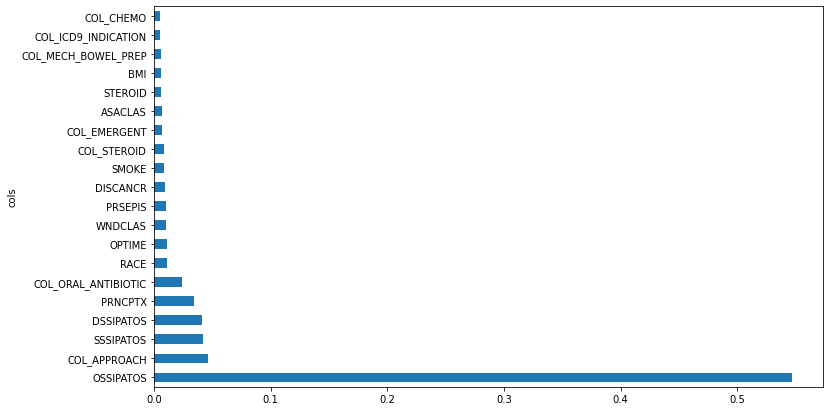

In [14]:
fi = rf_feat_importance(model2, X)
fi[:10]

plot_fi(fi[:20]);

In [15]:
rf_preds = (model.predict_proba(X_test))[:,1]
%store rf_preds
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
%store rf_fpr
%store rf_tpr

Stored 'rf_preds' (ndarray)
Stored 'rf_fpr' (ndarray)
Stored 'rf_tpr' (ndarray)


In [16]:
xgb_preds = (model2.predict_proba(X_test))[:,1]
%store xgb_preds
xgb_fpr_ssi, xgb_tpr_ssi, _ = roc_curve(y_test, xgb_preds)
%store xgb_fpr_ssi
%store xgb_tpr_ssi

Stored 'xgb_preds' (ndarray)
Stored 'xgb_fpr_ssi' (ndarray)
Stored 'xgb_tpr_ssi' (ndarray)


In [17]:
rf_prec_ssi, rf_rec_ssi, _ = precision_recall_curve(y_test, rf_preds)


In [18]:
xgb_prec_ssi, xgb_rec_ssi, _ = precision_recall_curve(y_test, xgb_preds)


In [19]:
%store rf_prec_ssi
%store rf_rec_ssi


Stored 'rf_prec_ssi' (ndarray)
Stored 'rf_rec_ssi' (ndarray)


In [20]:
%store xgb_prec_ssi
%store xgb_rec_ssi

Stored 'xgb_prec_ssi' (ndarray)
Stored 'xgb_rec_ssi' (ndarray)


In [21]:
def roc_prc_ci(y_true, y_score, positive=1):
    AUC = average_precision_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)
roc_prc_ci(y_test, rf_preds)


(0.4758254450167216, 0.4839093467820459, 0.4919932485473702)

In [22]:

roc_prc_ci(y_test, xgb_preds)

(0.4767823816846184, 0.48487104729586444, 0.4929597129071105)

In [23]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

In [24]:
roc_auc_ci(y_test, rf_preds)

(0.7565609862546359, 0.7642216843579279, 0.77188238246122)

In [25]:
roc_auc_ci(y_test, xgb_preds)

(0.7591024550642778, 0.7667398233020337, 0.7743771915397897)

In [26]:
def acc(model1, X, y):
    preds = model1.predict(X)
    pscore = accuracy_score(y, preds)
    print('acc', pscore)
acc(model2, X_test, y_test)

acc 0.9232975609756098


In [27]:
def recall(model1, X, y):
    preds = model1.predict(X)
    pscore = recall_score(y, preds)
    print('sensitivity', pscore)
recall(model2, X_test, y_test)

sensitivity 0.26912339475153546


In [28]:
y_test.value_counts(normalize=True)

0    0.895161
1    0.104839
Name: ssi, dtype: float64

In [29]:
xgbpreds = model2.predict_proba(X_test)
xgbpreds10 = xgbpreds[:,1]

In [30]:
xgbpreds10[xgbpreds10 >= 0.1] = 1
xgbpreds10[xgbpreds10 < 0.1] = 0
tn, fp, fn, tp = confusion_matrix(y_test, xgbpreds10).ravel()
(tn, fp, fn, tp)

(34335, 11542, 1932, 3441)

In [31]:
accuracy_score(y_test, xgbpreds10)

0.7370926829268293

In [32]:
xgbpreds10[xgbpreds10 >= 0.08] = 1
xgbpreds10[xgbpreds10 < 0.08] = 0
tn, fp, fn, tp = confusion_matrix(y_test, xgbpreds10).ravel()
(tn, fp, fn, tp)

(34335, 11542, 1932, 3441)

y1 = data['READMPODAYS1']
X1 = data.drop(['READMISSION1', 'READMPODAYS1'], axis=1)